# Working with the GeoMIP (and CMIP6) cloud-store

## This notebook demonstrates usage of the Google Cloud Store hosted version of cloud-optimised (zarr) data for the G6sulfur GeoMIP scenario

This is data which was ingested into the store from ESGF by Julius Busecke, supported by Reflective, in August 2025.

See here for an overview of how to work with this kind of data: https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#loading-an-esm-collection

And here for some more specific guidance https://github.com/leap-stc/cmip6-leap-feedstock#how-to-access-the-newly-uploaded-data

In [32]:
import intake # see https://intake-esm.readthedocs.io/en/stable/index.html

# uncomment/comment lines to swap catalogs; use the first, unless deliberately testing 
url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog.json" # Only stores that pass current tests
#url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog_noqc.json" # Only stores that fail current tests
# url = "https://storage.googleapis.com/cmip6/cmip6-pgf-ingestion-test/catalog/catalog_retracted.json" # Only stores that have been retracted by ESGF
col = intake.open_esm_datastore(url)

In [49]:
# form query dictionary
query = dict(experiment_id=['ssp245', 'ssp585', 'G6sulfur'],
             table_id='Amon',
             variable_id=['tas'],
             )

# the line above returns all data across these scenarios, but we really only want..
# ..models for which all three scenarios are available, so we subset:

# subset catalog and get some metrics grouped by 'source_id'
col_subset = col.search(require_all_on=['source_id', 'institution_id'], **query)
col_subset.df.groupby('source_id')[['experiment_id', 'variable_id', 'table_id']].nunique() # this line just shows us the data we have

,experiment_id,variable_id,table_id
source_id,,,
CNRM-ESM2-1,3,1,1
IPSL-CM6A-LR,3,1,1
MPI-ESM1-2-LR,3,1,1
UKESM1-0-LL,3,1,1


In [50]:
from xmip.preprocessing import combined_preprocessing
ddict = col_subset.to_dataset_dict(preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


# Example Usage

We will recreate figure 1 from Visioni et al., 2021; https://acp.copernicus.org/articles/21/10039/2021/acp-21-10039-2021.html


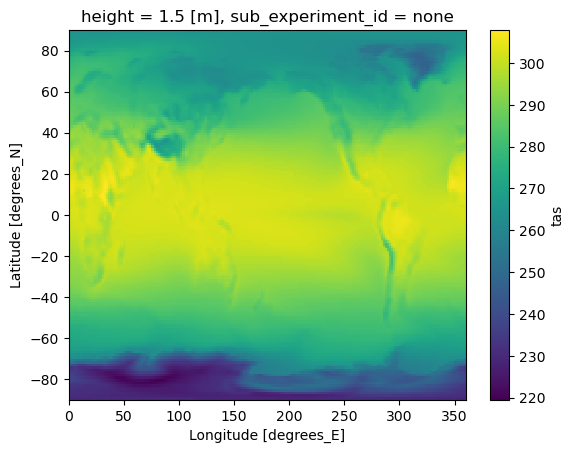

In [63]:
# the xarray datasets themselves are stored in the dictionary ddict, which has keys in the format shown below:
ds = ddict['GeoMIP.MOHC.UKESM1-0-LL.G6sulfur.Amon.gn']
ds.mean(dim=['time', 'variant_label']).tas.plot()

Processing: GeoMIP.CNRM-CERFACS.CNRM-ESM2-1.G6sulfur.Amon.gr
Processing: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr
Processing: ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn
Processing: ScenarioMIP.CNRM-CERFACS.CNRM-ESM2-1.ssp245.Amon.gr
Processing: GeoMIP.IPSL.IPSL-CM6A-LR.G6sulfur.Amon.gr
Processing: ScenarioMIP.CNRM-CERFACS.CNRM-ESM2-1.ssp585.Amon.gr
Processing: GeoMIP.MPI-M.MPI-ESM1-2-LR.G6sulfur.Amon.gn
Processing: GeoMIP.MOHC.UKESM1-0-LL.G6sulfur.Amon.gn
Processing: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp245.Amon.gr
Processing: ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn
Processing: ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Amon.gn
Processing: ScenarioMIP.MOHC.UKESM1-0-LL.ssp245.Amon.gn


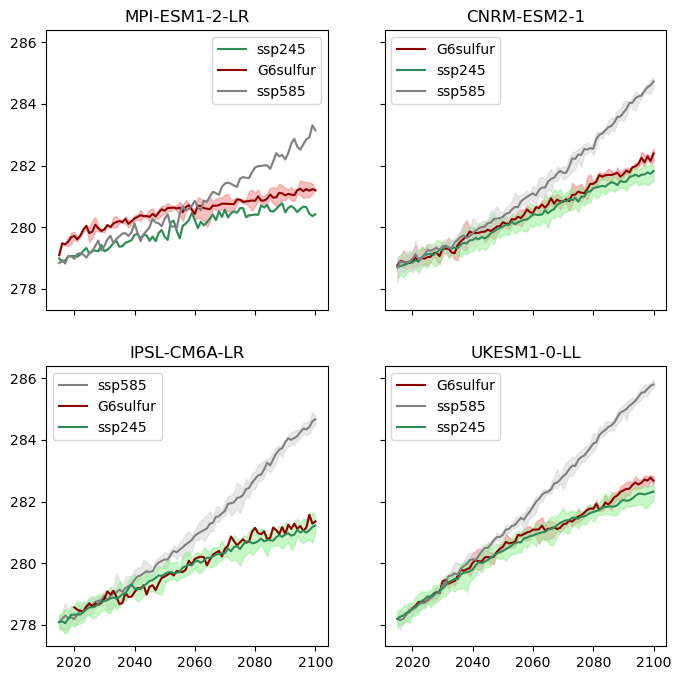

In [64]:
## we can iterate over the returned datasets to plot across models, scenarios and ensemble members:

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True, sharex=True)

models = list(set([key.split('.')[2] for key in ddict.keys()])) # get a list of the unique models in the ddict
ax_dict = dict(zip(models, range(len(models)))) # we are going to loop over the datasets, not the models, so define a dict to decide which ax to plot onto

color_dict = {'G6sulfur':'darkred', 'ssp585':'gray', 'ssp245':'seagreen'}
light_color_dict = {'G6sulfur':'lightcoral', 'ssp585':'lightgray', 'ssp245':'lightgreen'}

for key, ds in ddict.items():
    print(f"Processing: {key}")
    model, experiment = key.split('.')[2], key.split('.')[3]
    
    global_mean_tas = ds.sel(time=slice('2015', '2100'))['tas'].mean(dim=['y', 'x','sub_experiment_id'], skipna=True)
    annual_global_mean_tas = global_mean_tas.groupby(global_mean_tas.time.dt.year).mean() # strictly, I should weight by month length here, but I don't for this quick visualisation

    ens_mean = annual_global_mean_tas.mean('variant_label')
    ens_max = annual_global_mean_tas.max('variant_label')
    ens_min = annual_global_mean_tas.min('variant_label')
    
    ax = axs.flatten()[ax_dict[model]]
    ax.set_title(model)
    ax.plot(ens_mean.year.values, ens_mean.values, label=experiment, c=color_dict[experiment])
    ax.fill_between(ens_max.year.values, ens_min.values, ens_max.values, color=light_color_dict[experiment], alpha=0.5)
        
for ax in axs.flatten():
    ax.legend()
    
plt.show()